In [31]:
# Clean up the memory
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import gc

import numpy as np
import math

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

In [3]:
def save_session(filename, nb_iterations = -1):
    '''
    Saves a seesion in a file with the given filename
    A number of iterations can also be given 
    :param : String
    :param : int
    '''
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    if nb_iterations >= 0:
        saver.save(sess, SESSION_FOLDER + filename, global_step=nb_iterations)
    else:
        saver.save(sess, SESSION_FOLDER + filename)
        
    print("Session saved with filename {}.".format(filename))
    
def restore_session(filename):
    '''
    Restores a tensorflow session stored in the given filename
    After the call of this function, the sessios's variable will be available again
    :param : String
    '''
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph(SESSION_FOLDER + filename + '.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))
        
def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [4]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(2*mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))

In [5]:
def plot_history(history):
    '''
    Plots the history of the training error
    Usefull 
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

In [6]:
# Use non normalized feature matrix
# For now best results are given with this one
X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")

# Use normalized feature matrix
#X = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

#X = normalize(X)

In [7]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 15961)
y: (30049,)


# Single neural network model approach

First we will do a single model approach, the goal is to see quickly how we can build a model using neural networks and how well it does. 

In [8]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Assuming each layer represent a link between particules, we begin with 4 layers
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [9]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 100
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.2
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24039 samples, validate on 6010 samples
Epoch 1/100
24039/24039 [==============================] - 8s 328us/step - loss: 31.2613 - mean_absolute_error: 2.6472 - val_loss: 2.1992 - val_mean_absolute_error: 1.1006
Epoch 2/100
24039/24039 [==============================] - 7s 282us/step - loss: 2.4422 - mean_absolute_error: 1.2500 - val_loss: 2.9184 - val_mean_absolute_error: 1.4392
Epoch 3/100
24039/24039 [==============================] - 7s 280us/step - loss: 1.9160 - mean_absolute_error: 1.1136 - val_loss: 2.9265 - val_mean_absolute_error: 1.4679
Epoch 4/100
24039/24039 [==============================] - 7s 277us/step - loss: 1.6569 - mean_absolute_error: 1.0454 - val_loss: 2.1024 - val_mean_absolute_error: 1.2046
Epoch 5/100
24039/24039 [==============================] - 7s 283us/step - loss: 1.4973 - mean_absolute_error: 1.0088 - val_loss: 0.9122 - val_mean_absolute_error: 0.7115
Epoch 6/100
24039/24039 [==============================] - 7s 296us/step - loss: 1.3447 - mean_

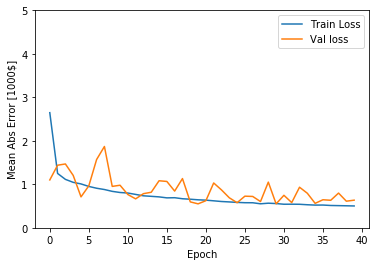

In [10]:
plot_history(history)

In [11]:
result = model.predict(X, batch_size=32)
rmse(result, y)

0.8584572139402442

## Results

For the following model :
    - 4 hidden layers of 64 neurons - relu activation.
    - A result layer of 1 neuron - relu activation.
    - Trained on 10 epochs.
    - No cross validation.
The MSE obtained is 0.2768, RMSE is 0.6349